### Load in necessary libraries

In [1]:
import os
import sys
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Data_Process/scripts/")

In [3]:
from util import *
%load_ext autoreload
%autoreload 2

### Import all data 

In [4]:
DIRPATH = f"{home}/Documents/projects/CarPriceRegression/carPrice/"
EXT = ".csv"

In [5]:
data = readData(DIRPATH,EXT)

In [6]:
data.shape

(99187, 10)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99187 entries, 0 to 10667
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         99187 non-null  object 
 1   year          99187 non-null  int64  
 2   price         99187 non-null  int64  
 3   transmission  99187 non-null  object 
 4   mileage       99187 non-null  int64  
 5   fuelType      99187 non-null  object 
 6   tax           99187 non-null  int64  
 7   mpg           99187 non-null  float64
 8   engineSize    99187 non-null  float64
 9   brand         99187 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 8.3+ MB


In [8]:
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000
mean,2017.087723,16805.347656,23058.914213,120.299838,55.166825,1.663280
std,2.123934,9866.773417,21148.523721,63.150926,16.138522,0.557646
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7425.000000,125.000000,47.100000,1.200000
50%,2017.000000,14495.000000,17460.000000,145.000000,54.300000,1.600000
75%,2019.000000,20870.000000,32339.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


### Observations:

* There are zero null values
* model and transmission are object type and the rest are numeric type 
* year, tax, and engineSize require some feature transformation

### Remove tax column since tax is a product of price. The more price you pay for a car, the more sales tax you pay. It is almost an after effect of a price. It is also not a vital decision on how much people are willing to pay for a car since tax is very standard across all cars. 

In [9]:
data.drop("tax",axis=1,inplace=True)

### Garbage Collect

In [10]:
gc.collect()
%reset -f out

Flushing output cache (2 entries)


### Make sure the price has a normal distribution

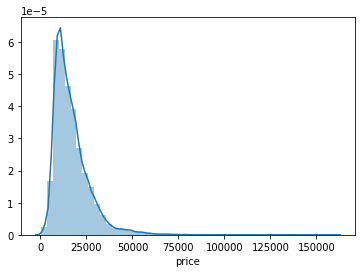

In [11]:
sns.distplot(data.price)
plt.show()

### Appears to be normal distribution for regression 

-----

### Look at relationship among features

### Year

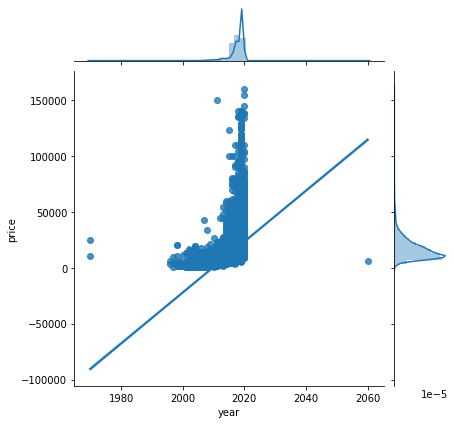

In [12]:
sns.jointplot(data=data,
             x="year",
             y="price",
             kind="reg")
plt.show()

### Although you see a trend by seaborn, there isn't a clear trend if you treat year as a continous variable

### Let's look at them as categorical variable

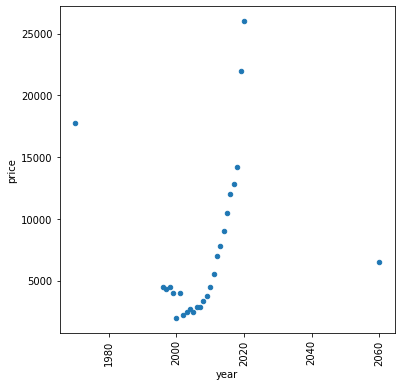

,year,price
26,2060,1
0,1970,2
1,1996,2
2,1997,4
4,1999,6


In [13]:
EDA_CAT_func("year","price",data,12,(6,6),(6,5))[:5]

### observations:
   * remove entries that are in 2060, probably a typo
   * combine years into "0" (O), "2"(>10year old), "3"(>5 year old),"4" (<=2 yr old), "5"(<1 yrold)
   * overall price increases with year which made sense 
   * There are a lot of outliers as well. 
   * probably good idea to turn this feature into a categorical feature

In [14]:
# remove 2060 
data_trimmed = data[(data.year<2060)]
# bin the years before 
bins = {(1970,2000):"0",(2001,2010):"1",
        (2011,2015):"2",(2016,2018):"3",
        (2019,2020):"4"}

In [15]:
data_trimmed["binned_year"]=data_trimmed.year.apply(lambda x:
                                                   binning_func(x,bins))

# remove year col

data_trimmed.drop("year",axis=1,inplace=True)

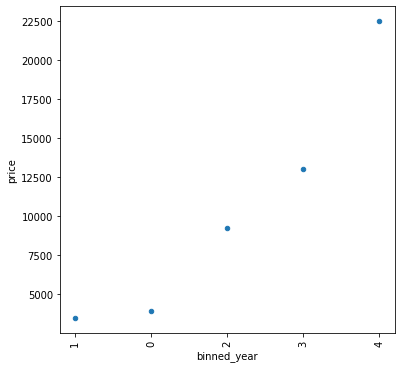

,binned_year,price
0,0,31
1,1,1273
2,2,15399
4,4,31236
3,3,51247


In [16]:
EDA_CAT_func("binned_year", "price", data_trimmed, 12,(6,6),(3,9))

### Now you see more of a clear indication of trend. 

### mileage

* Look at scatter plot relationship

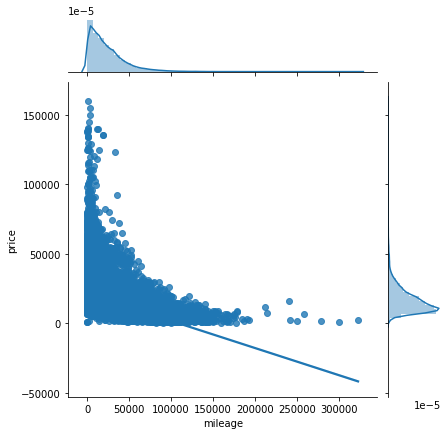

In [17]:
sns.jointplot(data=data_trimmed,
             x="mileage",
             y="price",
             kind="reg")
plt.show()

### It might better to turn milage into categorical features to get a better relationship

### We will bin the features into 6 categories:
  * 0: <= 3000
  * 1: <= 10000 
  * 2: <= 30000
  * 3: <= 60000
  * 4: <= 100000
  * 5: > 100000

In [18]:
mil_thresholds = {(0,3000):"0",
             (3001,10000):"1",
             (10001,30000):"2",
             (30001,60000):"3",
             (60001,100000):"4",
             (100001,350000):"5"}

In [19]:
data_trimmed["mil_cat"] = data_trimmed.mileage.apply(lambda x: binning_func(x, mil_thresholds))
# remove old milage column
data_trimmed.drop("mileage",axis=1,inplace=True)

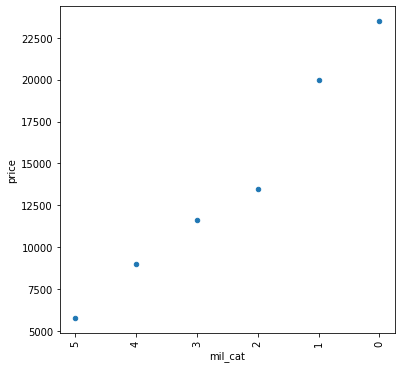

,mil_cat,price
5,5,804
4,4,5319
0,0,11218
1,1,20530
3,3,22014
2,2,39301


In [20]:
EDA_CAT_func("mil_cat","price",data_trimmed,12,(6,6),(1,6))

### Much better and see a clear indication of price drop as mileage goes down

### mpg

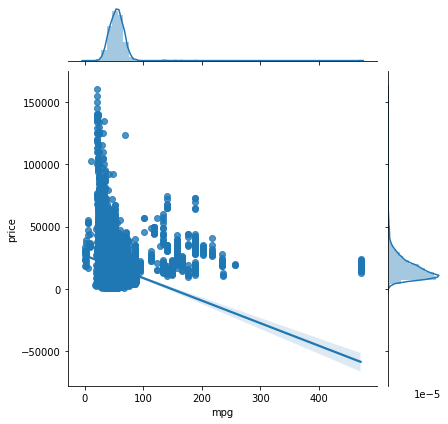

In [21]:
sns.jointplot(data=data_trimmed,
             x="mpg",
             y="price",
             kind="reg")
plt.show()

### Not a clear relationship, let's try to bin again to group into high low gas milage

In [22]:
data_trimmed.mpg.describe()

count    99186.000000
mean        55.166950
std         16.138556
min          0.300000
25%         47.100000
50%         54.300000
75%         62.800000
max        470.800000
Name: mpg, dtype: float64

In [23]:
bin_mpg = {(0,16):"0",
            (16,40):"1",
            (40,50):"2",
             (50,62):"3",
             (62,475):"4"}

In [24]:
data_trimmed["binned_mpg"]=data_trimmed.mpg.apply(lambda x:
                                                 binning_func(x,bin_mpg))
# drop mpg column
data_trimmed.drop("mpg",axis=1,inplace=True)

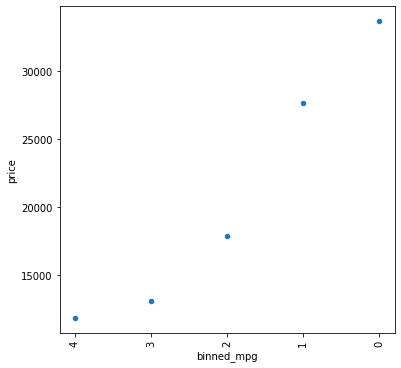

,binned_mpg,price
0,0,35
1,1,11022
2,2,23804
4,4,25909
3,3,38416


In [25]:
EDA_CAT_func("binned_mpg","price",data_trimmed,12,(6,6),(2,3))

### It makes sense that low gas milage implies more exotic car so less efficient fuel. 

### Engine Size

### There are 40 engineSize, let's look at them as cateogrical value

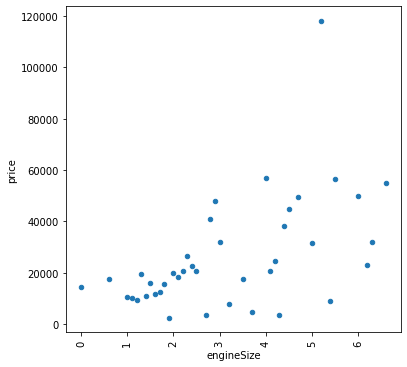

,engineSize,price
28,4.3,1
38,6.3,1
34,5.4,1
30,4.5,1
24,3.7,2
26,4.1,2
39,6.6,2
36,6.0,2
1,0.6,7
18,2.7,8


In [26]:
EDA_CAT_func("engineSize","price",data_trimmed,12,(6,6),(5,8))[:10]

### Will definitely benefit from grouping into categories of engineSize

In [27]:
bin_engine = {(0.0,2.0):"0",
              (2.1,4.0):"1",
              (4.1,6.8):"2"}

In [28]:
data_trimmed["engine_binned"] = data_trimmed.engineSize.apply(lambda x:
                                                             binning_func(x,bin_engine))
# remove engine
data_trimmed.drop("engineSize",axis=1,inplace=True)

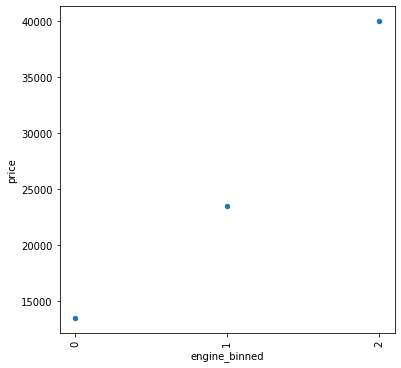

,engine_binned,price
2,2,271
1,1,11241
0,0,87674


In [29]:
EDA_CAT_func("engine_binned","price",data_trimmed,12,(6,6),(3,2))

### Much better. You see a clear trend as the engine goes up, it costs more. 

### Look at object type cols: transmission, fuelType, model

In [30]:
data_trimmed.transmission.unique()

array(['Manual', 'Automatic', 'Semi-Auto', 'Other'], dtype=object)

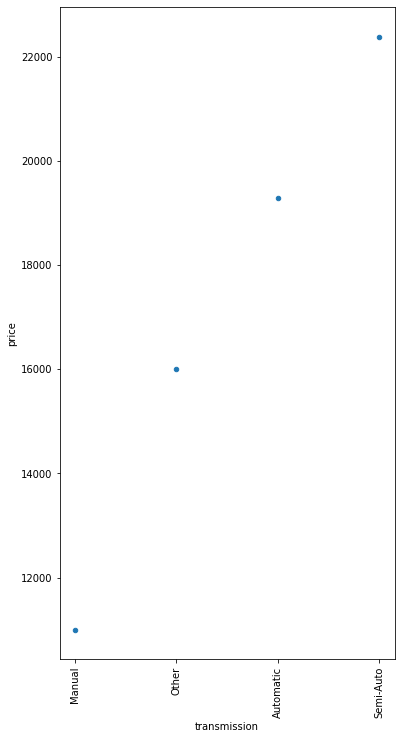

,transmission,price
2,Other,9
0,Automatic,20055
3,Semi-Auto,22677
1,Manual,56445


In [31]:
EDA_CAT_func("transmission","price",data_trimmed,12,(6,12),(2,2))

### It appears that manual is the cheapest and semi-auto is the most expensive

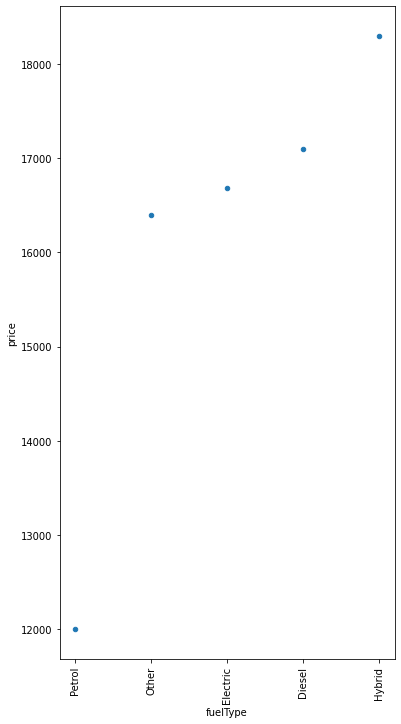

,fuelType,price
1,Electric,6
3,Other,247
2,Hybrid,3078
0,Diesel,40928
4,Petrol,54927


In [32]:
EDA_CAT_func("fuelType","price",data_trimmed,12,(6,12),(3,2))

### petrol tends to be least expensive and hybrid is the most.  But definitely see a correlation. 

### brand and model

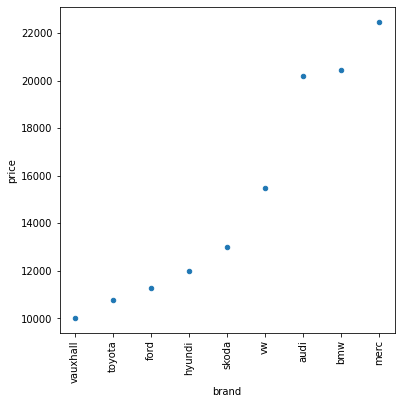

,brand,price
3,hyundi,4860
5,skoda,6267
6,toyota,6738
0,audi,10668
1,bmw,10781
4,merc,13119
7,vauxhall,13632
8,vw,15157
2,ford,17964


In [33]:
EDA_CAT_func("brand","price",data_trimmed,12,(6,6),(100,100))

### There appears to be a clear trend among car brands

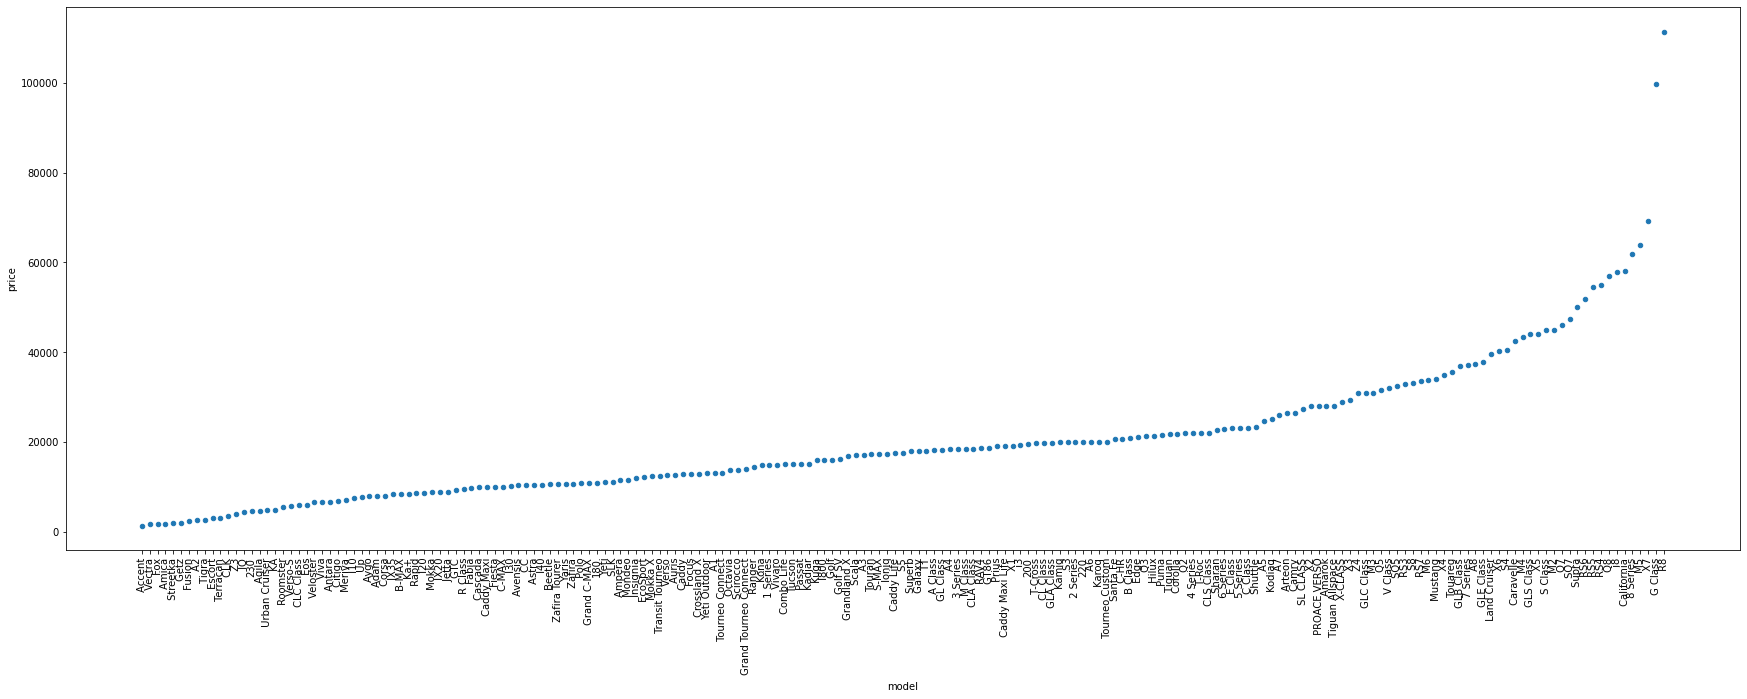

,model,price
194,230,1
17,Accent,1
58,Escort,1
163,Transit Tourneo,1
10,A2,1
193,220,1
21,Amica,1
130,RS7,1
131,Ranger,1
191,180,1


In [34]:
EDA_CAT_func("model","price",data_trimmed,12,(30,10),(100,100))[:10]

### There is definitely a correlation between car model and car price 
### let's see if we can combine car model and brand (some brand may have the same brand with the same model name

In [35]:
data_trimmed["model_brand"]=data_trimmed.model+"_"+data_trimmed.brand

In [36]:
data_trimmed.model_brand.nunique(), data_trimmed.model.nunique()

(195, 195)

### There appears to be no car brand with the same model name

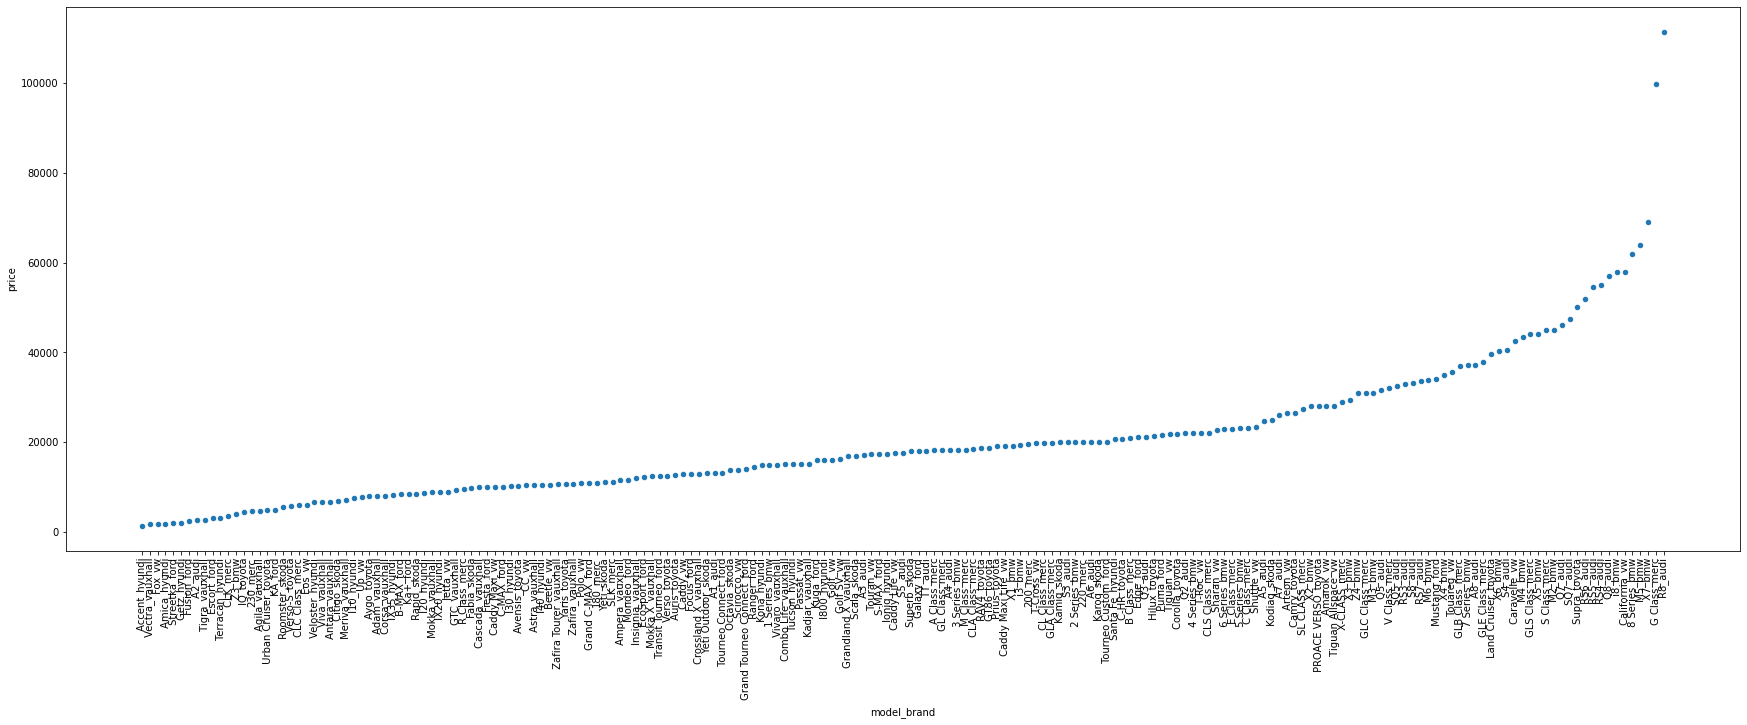

,model_brand,price
194,230_merc,1
17,Accent_hyundi,1
58,Escort_ford,1
163,Transit Tourneo_ford,1
10,A2_audi,1
193,220_merc,1
21,Amica_hyundi,1
130,RS7_audi,1
131,Ranger_ford,1
191,180_merc,1


In [37]:
EDA_CAT_func("model_brand","price",data_trimmed,12,(30,10),(100,100))[:10]

### Seems there are no repeats among model and brand, we will just keep the model column as categorical features

In [38]:
data_trimmed.drop(columns=["brand","model_brand"],inplace=True)

### Look at final data_trimmed 

In [39]:
data_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99186 entries, 0 to 10667
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   model          99186 non-null  object
 1   price          99186 non-null  int64 
 2   transmission   99186 non-null  object
 3   fuelType       99186 non-null  object
 4   binned_year    99186 non-null  object
 5   mil_cat        99186 non-null  object
 6   binned_mpg     99186 non-null  object
 7   engine_binned  99186 non-null  object
dtypes: int64(1), object(7)
memory usage: 6.8+ MB


### Check for feature correlation

#### factorize the columns then use spearman rank method first

In [40]:
df_categorized = data_trimmed.drop("price",axis=1).apply(lambda x : pd.factorize(x)[0])+1
df_categorized.corr(method='spearman', min_periods=1)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned
model,1.000000,0.054774,0.106497,0.008408,0.046815,0.007894,0.052920
transmission,0.054774,1.000000,0.254886,0.160406,0.111327,-0.039430,0.343046
fuelType,0.106497,0.254886,1.000000,0.007104,0.062014,-0.190108,0.270462
binned_year,0.008408,0.160406,0.007104,1.000000,0.489982,0.075040,0.005161
mil_cat,0.046815,0.111327,0.062014,0.489982,1.000000,0.025401,0.017751
binned_mpg,0.007894,-0.039430,-0.190108,0.075040,0.025401,1.000000,-0.145741
engine_binned,0.052920,0.343046,0.270462,0.005161,0.017751,-0.145741,1.000000


#### factorize the columns and add one use oneway chisquare test

In [41]:
df_categorized.corr(method=chiSquareTest, min_periods=1)

,model,transmission,fuelType,binned_year,mil_cat,binned_mpg,engine_binned
model,1.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0
transmission,0.0,1.000000e+00,0.028089,1.000000e+00,7.882175e-163,8.873848e-06,1.0
fuelType,0.0,2.808873e-02,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.0
binned_year,0.0,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,9.454172e-15,0.0
mil_cat,0.0,7.882175e-163,0.000000,1.000000e+00,1.000000e+00,0.000000e+00,0.0
binned_mpg,0.0,8.873848e-06,0.000000,9.454172e-15,0.000000e+00,1.000000e+00,0.0
engine_binned,0.0,1.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.0


#### Observation:
* Both spearman and chisquareTest showed that most variables don't have high correlation 
* spearman showed some correlatoin among:
   * fuelType and model
   * binned_year and transmission 
   * fuel_type and transmission 
   * transmission and binned_year
   * transmission and mil_cat
   * transmission and engine_binned 
   * binned_mpg and fuelType
   * engine_binned and fuelType 
   * binned_year and mil_cat
   * binned_year and binned_mpg 
   * engine_binned and binned_mpg 
* chisquare test showed correlation (pvalue > 0.025) among:
  * mil_cat and binned_year 
  * transmission and engine_binned
  * transmission and binned_year 
  * transmission and fuelType (pvalue is 0.028) 
  
 * Many of these correlation makes sense. 

### Save the dataset for machine learning with various categorical feature treatment. 

In [42]:
data_trimmed.to_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_data_merged.csv",index=False)